In [1]:
# Makes it easier to debug
%load_ext autoreload
#%load_ext line_profiler
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import torch.nn as nn
import typing as tp
from torch.nn import functional as F

import swyft
from swyft.lightning.components import (
    RatioEstimatorGaussian1d, MeanStd, SimpleDataset, subsample_posterior,
    get_1d_rect_bounds, append_randomized, valmap, SwyftModel, persist_to_file, 
    equalize_tensors, SwyftTrainer, SampleStore, dictstoremap, DictDataset, SwyftModule, SwyftDataModule, RatioSamples,
    RatioSampleStore, file_cache, RatioEstimatorMLP1d
)

import lensing_model
from pytorch_lightning import loggers as pl_loggers

## Problem-specific analysis components

In [3]:
KNN = 3
SIGMA = 0.02
NPIX_SRC = NPIX_IMG = 100

class Model(SwyftModel):
    def slow(self, pars):
        torch.cuda.set_device(0)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)    
        x, y, phi, q, r_ein, slope = pars['z_lens']
        slope = 2.0
        src_image = pars['z_src'].cuda()
        img, coords = lensing_model.image_generator(x, y, phi, q, r_ein, slope, src_image)
        X, Y, Xsrc, Ysrc = coords
        kNN_idx = lensing_model.get_kNN_idx(X/5, -Y/5, Xsrc, Ysrc, k = KNN)  # TODO: Need to sort out strange 1/5 and -1/5 factors
        torch.set_default_tensor_type(torch.FloatTensor)
        return SampleStore(mu = img.cpu(), kNN_idx = kNN_idx.cpu(), X = X.cpu(), Y = Y.cpu(), Xsrc = Xsrc.cpu(), Ysrc = Ysrc.cpu())
    
    def fast(self, d):
        img = d['mu'] + torch.randn_like(d['mu'])*SIGMA
        return SampleStore(img=img)
    
    def prior(self, N, bounds = None):
        src_samples = self.prior_src(N, bounds = bounds)
        lens_samples = self.prior_lens(N, bounds = bounds)
        return SampleStore(**src_samples, **lens_samples)
    
    # Draw from source prior
    def prior_src(self, N, bounds = None):
        if bounds is None or 'z_src' not in bounds:
            R = lensing_model.RandomSource()
            z_src = torch.stack([R().cpu() for _ in range(N)])
        else:
            n = 3
            l, h = bounds['z_src'].low, bounds['z_src'].high
            R = lensing_model.RandomSource()
            z_src = []
            for _ in range(N):
                rnd = sum([R().cpu()-R().cpu() for _ in range(n)])
                rnd -= rnd.min()
                rnd /= rnd.max()
                z_src.append(l+rnd*h)
            z_src = torch.stack(z_src)
        return SampleStore(z_src=z_src)

    def prior_lens(self, N, bounds = None):
        if bounds is not None:
            low = bounds['z_lens'].low
            high = bounds['z_lens'].high
        else:
            low =  np.array([-0.2, -0.2, 0, 0.2, 1.0, 1.5])
            high = np.array([0.2, 0.2, 1.5, 0.9, 2.0, 2.5])
        draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
        return SampleStore(z_lens = torch.tensor(draw).float())

In [4]:
m = Model()

## Definition of target image

In [5]:
#s_targets = m.sample(10)
#torch.save(s_targets, "test_targets.pt")
s_targets = torch.load("test_targets.pt")

tensor([-0.0149, -0.1251,  0.8492,  0.7843,  1.8083,  1.9215])


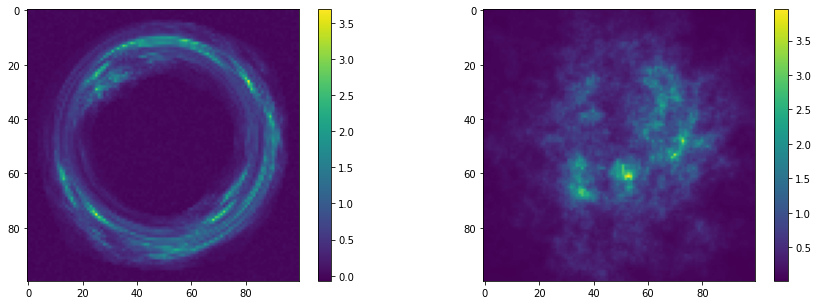

In [6]:
s0 = s_targets[3]
print(s0['z_lens'])
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(s0['img'])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(s0['z_src'])
plt.colorbar()

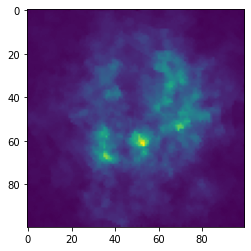

In [7]:
rec = lensing_model.deproject_idx(s0['img'].unsqueeze(0), s0['kNN_idx'].unsqueeze(0)).mean(axis=1).squeeze(0)
plt.imshow(rec)

In [8]:
class LensNetwork(SwyftModule):
    def __init__(self):
        super().__init__()
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(dict(img = (NPIX_IMG, NPIX_IMG)))
        self.CNN = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(10, 20, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(20, 40, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.LazyLinear(128),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 16),
        )
        #self.ptrans = swyft.networks.ParameterTransform(
        #    6, [(0,), (1,), (2,), (3,), (4,), (5,)], online_z_score=False
        #)
        #n_marginals, n_block_parameters = self.ptrans.marginal_block_shape
        #n_observation_features = 16
        #self.classifier = swyft.networks.MarginalClassifier(
        #    n_marginals,
        #    n_observation_features + n_block_parameters,
        #    hidden_features=64,
        #    dropout_probability = 0.1,
        #    num_blocks=2,
        #)
        
        self.c = RatioEstimatorMLP1d(16, 6)
        
    def forward(self, x, z):
        # Digesting x
        x = dict(img = x['img'])
        x = self.online_z_score(x)['img']
        x = self.CNN(x.unsqueeze(1)).squeeze(1)
        
        # Digesting z
        z = z['z_lens']
        
        out = self.c(x, z)
        return dict(z_lens = out)
        
        
        x, z = equalize_tensors(x, z)
        z = self.ptrans(z)
        
        # Combine!
        
        ratios = self.classifier(x, z)
        #ratios = ratios.unsqueeze(-1)
        #ratios = torch.cat([ratios, z], dim=-1)
        w = RatioSamples(z.squeeze(-1), ratios)
        return dict(z_lens=w)

In [9]:
class SourceNetwork(SwyftModule):
    def __init__(self):
        super().__init__()
        self.l = torch.nn.Linear(10, 10)
        self.reg1d = RatioEstimatorGaussian1d(momentum = 0.1)
        self.L = torch.nn.Linear(NPIX_SRC**2, NPIX_SRC**2)
        
    def get_img_rec(self, x):
        x_img = x['img']
        x_kNN_idx = x['kNN_idx']
        x_src_rec = lensing_model.deproject_idx(x_img, x_kNN_idx)[:,:,:,:].mean(dim=1)
        x_src_rec = self.L(x_src_rec.view(-1, NPIX_SRC*NPIX_SRC)).view(-1, NPIX_SRC, NPIX_SRC)*0 + x_src_rec
        return x_src_rec
    
    def forward(self, x, z):
        x_img_rec = self.get_img_rec(x)
        z_src = z['z_src']
        x_img_rec, z_src = equalize_tensors(x_img_rec, z_src)
        w = self.reg1d(x_img_rec, z_src)
        #w = RatioSamples(ratios[...,1], ratios[...,0])
        return dict(z_src = w)

# Workflow

In [10]:
Ntrain1, R1, ME = 500, 2, 20
TARGET = 3
tag = 'V02'
INFER_SOURCE = True

In [11]:
bounds = None
results = []
s0 = s_targets[TARGET]
for i in range(R1):
    tbl = pl_loggers.TensorBoardLogger("lightning_logs", name = 'lensing_%s'%tag)#, default_hp_metric=True)
    # s1: img, lens, src ~ p(img|lens, src)p(lens)p(src)
    s1 = file_cache(lambda: m.sample(Ntrain1, bounds = bounds), './train_data_%s_%i_%i_%i.pt'%(tag, TARGET, Ntrain1, i))
    
    # r1: p(z_lens|img)/p(z_lens)
    r1 = LensNetwork()
    
    # d1: split img vs z_lens
    # TODO: Specify x_keys = ['img'], z_keys=['z_lens']
    d1 = SwyftDataModule(s1, model = m, batch_size = 128)
    
    # Train r1 with d1
    t1 = SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = ME, logger = tbl)
    t1.fit(r1, d1)
    t1.test(r1, d1)
    
    # p1: z_lens ~ p(z_lens|img_obs)  --  these are weighted samples
    p1 = t1.infer(r1, d1, condition_x = s0)

    if INFER_SOURCE:
        # r2: p(src|z_lens, img)/p(src)
        r2 = SourceNetwork()

        # d2: split (img, kNN_idx) vs src
        # TODO: Specify x_keys = ['img', 'kNN_idx'], z_keys=['src']
        d2 = SwyftDataModule(s1, model = m, batch_size = 16)

        # Train r2 with d2
        t2 = SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 2, logger = tbl)
        t2.fit(r2, d2)

        # d3: img, lens, src ~ p(img|lens, src)p(lens|img_obs)
        s3 = m.sample(100, bounds = bounds, effective_prior = {'z_lens': p1})

        # d3: split (img, kNN) vs (z_lens, src)
        # TODO: Specify x_keys = ['img', 'kNN_idx'], z_keys=['z_lens', 'src']
        d3 = SwyftDataModule(s3, model = m, batch_size = 16)

        # ws2: src ~ p(src|img_obs) = \int dlens p(src|lens, img_obs)*p(lens|img_obs)  --  weighted samples
        p2 = t2.infer(r2, d3, condition_x = s0)

        # Rectangle Bounds
        all_inference = dict(**p1, **p2)
    else:
        all_inference = p1
        p2 = None
        
    bounds = get_1d_rect_bounds(all_inference, th = 1e-6)  # for p(z_lens)
    #results.append(dict(bounds = bounds, t1=t1, t2=t2, d1=d1, ws1=ws1, ws2=ws2))
    results.append(dict(p1=p1, p2=p2, bounds = bounds))
    
    # Making nice plots
    
    z = p1.sample(10000)['z_lens'].numpy()
    zr = p1.sample(10000000, replacement = False)['z_lens'].numpy()
    for k in range(6):
        fig = plt.figure(dpi = 100)
        plt.hist(zr[:,k], density = True, bins = 20)
        plt.hist(z[:,k], density = True, bins = 20)
        plt.axvline(s0['z_lens'][k], color='r')
        tbl.experiment.add_figure("posterior/%i"%k, fig)
        
    fig = plt.figure()
    key = 'z_lens'
    for k in range(6):
        l, h = bounds[key].low[k], bounds[key].high[k]
        plt.plot([k, k], [l, h], 'k')
        plt.scatter(k, s0[key][k], marker='o', color='r')
    tbl.experiment.add_figure("bounds", fig)

    for k in range(8):
        fig = plt.figure()
        img = s1[k]['img']
        plt.imshow(img)
        tbl.experiment.add_figure("train_data/%i"%k, fig)
        
    for k in range(8):
        fig = plt.figure()
        img = s1[k]['z_src']
        plt.imshow(img)
        tbl.experiment.add_figure("train_data_src/%i"%k, fig)
        
    fig = plt.figure()
    plt.imshow(s0['img'])
    tbl.experiment.add_figure("target/image", fig)
    fig = plt.figure()
    plt.imshow(s0['z_src'])
    tbl.experiment.add_figure("target/source", fig)

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/utilities/model_summary.py:438: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name           | Type                         | Params
----------------------------------------------------------------
0 | online_z_score | OnlineDictStandardizingLayer | 0     
1 | CNN            | Sequential                   | 13.3 K
2 | c        

Validation sanity check: 0it [00:00, ?it/s]

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/_reduction.py:42: UserWarning: size_avera

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': 5.915414333343506, 'hp/KL-div': -4.235804080963135}
--------------------------------------------------------------------------------


/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 4it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params
---------------------------------------------------
0 | l     | Linear                   | 110   
1 | reg1d | RatioEstimatorGaussian1d | 0     
2 | L     | Linear                   | 100 M 
---------------------------------------------------
100 M     Trainable params
0         Non-trainable params
100 M     Total params
400.040   Total estimated model params size (MB)
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory lightning_logs/lensing_V02/version_3/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]/home/weniger/codes/swyft_papergui/notebooks/GUI paper/lensing_model.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image_array)
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|██████████| 100/100 [00:00<00:00, 9783.32it/s

Predicting: 25it [00:00, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 10255.37it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                         | Params
----------------------------------------------------------------
0 | online_z_score | OnlineDictStandardizingLayer | 0     
1 | CNN            | Sequential                   | 13.3 K
2 | c              | RatioEstimatorMLP1d          | 110 K 
----------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.494     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`